In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import scipy.io
import datetime
import dateutil
import numpy as np
import pandas as pd
import sklearn.model_selection
import tensorflow as tf
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
IMAGE_DIRECTORY = 'imdb_crop'
IMDB_MATDB_FILE = os.path.join(IMAGE_DIRECTORY, 'imdb.mat')
IMAGE_HEIGHT_PIXELS = 224
IMAGE_WIDTH_PIXELS = 224
IMAGE_COLOR_CHANNELS = 3

Image metadata from the IMDb Face Only data set is stored in a MATLAB binary database file - which is great for the storage of variables, functions, arrays and other information - and contains the following fields:

* **dob** - the celebrity's cate of birth, expressed as a MATLAB serial date number
* **photo_taken** - the year the photo was taken 
* **full_path** - the path to the corresponding image file
* **gender** - the celebrity’s gender expressed as 0 = Female, 1 = Male or NaN (Not a Number) if unknown
* **name** - the elebrity’s name
* **face_location** - four coordinates specifying where in the image the face is located
* **face_score** - a face detector score (the higher the better) with a Inf (infinity) value indicating that no face was found
second_face_score - a second face detector score where a value of *NaN* means no second face was detected
* **celeb_names** - a list of alternate names for the Celebrity
* **celeb_id** - a unique number associated to the Celebrity 

Unfortunately the MATLAB binary database format isn’t easily used by Python for data analytics and had to be converted before it was usable. For the conversion we turned to a Python library used for scientific, mathematics and engineering called SciPy. We used [SciPy's](https://www.scipy.org/) [scipy.io.loadmat](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.loadmat.html) function to read the file so data could be added to a Pandas DataFrame for easier manipulation.

In [3]:
matdb = scipy.io.loadmat(IMDB_MATDB_FILE)['imdb'][0, 0]
print('MATLAB database rows: {}'.format(str(len(matdb["face_score"][0]))))

MATLIB database rows: 460723


Great! We had 460,723 records.

But adding the metadata records directly from the MATLAB database file to a Pandas DataFrame wasn't a direct import and we needed to convert some of the data first.

The first conversion needed was to calculate the person's age - this information isn't available in the MATLAB database file. We used the **dob** (a MATLAB serial date number) and **photo_taken** (the year the photo was taken) fields to calculate an approximate age, +/- seven months. The function below was used to calculate the person's age:

In [4]:
def calculate_age(dob, photo_taken_year):
    days = dob % 1
    birth_date = datetime.date.fromordinal(dob) + datetime.timedelta(days=days) - datetime.timedelta(days=366)
    return dateutil.relativedelta.relativedelta(datetime.date(photo_taken_year, 7, 1), birth_date).years

In [5]:
def get_age_range_id(age):
    if age < 18:
        return 0
    if age <= 24:
        return 1
    if age <= 34:
        return 2
    if age <= 44:
        return 3
    if age <= 54:
        return 4
    if age <= 64:
        return 5
    if age < 75:
        return 6
    return 7


def get_age_range_name(age_range_id):
    if age_range_id == 0:
        return '< 18'
    if age_range_id == 1:
        return '18 - 24'
    if age_range_id == 2:
        return '25 - 34'
    if age_range_id == 3:
        return '35 - 44'
    if age_range_id == 4:
        return '45 - 54'
    if age_range_id == 5:
        return '55 - 64'
    if age_range_id == 6:
        return '65 - 74'
    return '75+'

def get_gender_name(gender_id):
    if gender_id == 0:
        return 'Female'
    if gender_id == 1:
        return 'Male'
    return 'Unknown'

Next we needed to look at the **face_score** and **second_face_score** field values. We needed images containing only one face, and the face detection score should have a decent value. Since the values for the **face_score field** were vague - the higher the better - we started with a minimum value of 2.0 and used Numpy functions to skip over records with a **face_score** value of *Inf*. We also needed to skip records that had a **second_face_score value**, or where the image was missing. While we're iterating through this data set, we also assigned an age range to our data, and names and labels to both the age range and gender so we can more easily explore.

In [6]:
rows = []
MINIMUM_FACE_SCORE = 2.0

for i in range(len(matdb["face_score"][0])):
    dob = int(matdb["dob"][0][i])
    face_score = matdb["face_score"][0][i]
    second_face_score = matdb["second_face_score"][0][i]

    if dob <= 366:
        continue

    if face_score < MINIMUM_FACE_SCORE or np.isinf(face_score):
        continue
        
    if (~np.isnan(second_face_score)) and second_face_score > 0.0:
        continue

    file_path = os.path.join(IMAGE_DIRECTORY, matdb["full_path"][0][i][0])
    age = calculate_age(dob, int(matdb["photo_taken"][0][i]))
    gender_id = matdb["gender"][0][i]
    
    if os.path.isfile(file_path):
        gender_name = get_gender_name(gender_id)
        age_range_id = get_age_range_id(age)
        age_range_label = str(age_range_id)
        age_range_name = get_age_range_name(age_range_id)
        rows.append({'file_path': file_path, 'gender_id': gender_id, 'gender_name': gender_name,
                     'age': age, 'age_range_id': age_range_id, 'age_range_label': age_range_label,
                     'age_range_name': age_range_name})
    else:
        print('Image file does not exist! Skipping record for image: {}'.format(file_path))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136768 entries, 0 to 136767
Data columns (total 7 columns):
file_path          136768 non-null object
gender_id          134498 non-null float64
gender_name        136768 non-null object
age                136768 non-null int64
age_range_id       136768 non-null int64
age_range_label    136768 non-null object
age_range_name     136768 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 7.3+ MB


Now that our data was in an array, we could import the array into a Pandas DataFrame and then print out a concise summary of our data.

In [ ]:
df = pd.DataFrame(rows, columns=['file_path', 'gender_id', 'gender_name', 'age',
                                 'age_range_id', 'age_range_label', 'age_range_name'])
df.info()

The output from the Pandas [DataFrame.info()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html) function gives us a count of records, what fields are available, a count of non-null values for each field,  the data type for each field and the memory usage of the DataFrame. We can see from the "shape" of the data that we had 136,768 records, but the number of non-null **gender_id** records was only 134,498. Some of the records had a null **gender_id** value! Our **gender_id** field data type was also a float64, even though our data was an integer.

Our next step was to remove all duplicate records, drop records that had fields with null values and convert the **gender_id** field data type from a float64 to an int64.

In [7]:
df = df.drop_duplicates()
df = df.dropna()
df = df.astype({'gender_id': 'int64'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134498 entries, 0 to 136767
Data columns (total 7 columns):
file_path          134498 non-null object
gender_id          134498 non-null int64
gender_name        134498 non-null object
age                134498 non-null int64
age_range_id       134498 non-null int64
age_range_label    134498 non-null object
age_range_name     134498 non-null object
dtypes: int64(3), object(4)
memory usage: 8.2+ MB


The "shape" of our data looked much better after a few adjustments. All record fields have data, and our data types are as expected. We lost an additional 2,270 records from the cleaning process but we still had enough data to train our model.

Now that our data was clean, our next step was to look at the values of our data. The **age**, **age_range_id** and **gender_id** fields are numeric and were great candidates for descriptive statistical analysis. The Pandas [DataFrame.describe()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html) function already provides this functionality out-of-the-box, so we ran that function to understand our data's values better.

In [9]:
df.describe()

,gender_id,age,age_range_id
count,134498.000000,134498.000000,134498.000000
mean,0.518119,36.055183,2.634998
std,0.499673,12.969357,1.351856
min,0.000000,-30.000000,0.000000
25%,0.000000,27.000000,2.000000
50%,1.000000,34.000000,2.000000
75%,1.000000,43.000000,3.000000
max,1.000000,134.000000,7.000000


The output from the Pandas DataFrame.describe() function gives the count, mean, standard deviation, minimum, percentiles (25%, 50% and 75%) and maximum for each of the numeric fields in your DataFrame. The output tells us the following story:

* The Age field has a mean value of around 36.06 years of age, with the smallest value being -30 and the largest value being 134, and a standard deviation of around 12.97 years. The percentiles tell us that 25% of the records are younger than or equal to 27 years of age, 50% of the records are younger than or equal to 34 years of age and 75% of the records are younger than or equal to 43 years of age. Our data set looks to trend towards a younger age group.


* The Age Range field has a mean value of around 2.63 ("35 - 44"), with the smallest value being 0 (" < 18") and the largest value being 7 ("75+"), and a standard deviation of around 1.35 Age Ranges. The percentiles tell us that 25% of the records are less than or equal to 2 (“25 - 34”), 50% of the records are less than or equal to 2 (“25 - 34”) and 75% of the records are less than or equal to 3 ("35 - 44"). Our data set looks to trend towards the "25 - 34" age range.


* The Gender field has a mean value around 0.52, with the smallest being 0 (Female) and the largest being 1 (Male), and a standard deviation of around 0.4997. The percentiles tell us that 25% of the records are less than or equal to 0 (Female), 50% of the records are less than or equal to 1 (Male) and 75% of the records are less than or equal to 1 (Male). Our data set looks almost evenly distributed between Female and Male images.

That gave us a lot of great information about our data! We did, however, want to remove records that had a negative Age. Since we were thinking about Age, we also wanted to remove records of people that were below the Age of 13 and older than 80. So we did that and called the DataFrame.describe() function again to see how this impacted our data.


In [10]:
df.drop(df[ df.age < 13 ].index, inplace=True)
df.drop(df[ df.age > 80 ].index, inplace=True)
df.describe()

,gender_id,age,age_range_id
count,132077.000000,132077.000000,132077.000000
mean,0.519031,36.315225,2.660986
std,0.499640,12.307695,1.301717
min,0.000000,13.000000,0.000000
25%,0.000000,27.000000,2.000000
50%,1.000000,35.000000,3.000000
75%,1.000000,43.000000,3.000000
max,1.000000,80.000000,7.000000


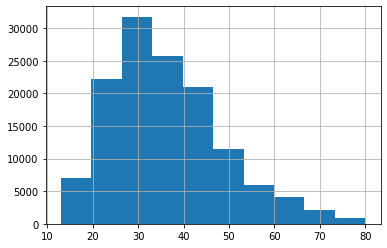

In [11]:
df['age'].hist()

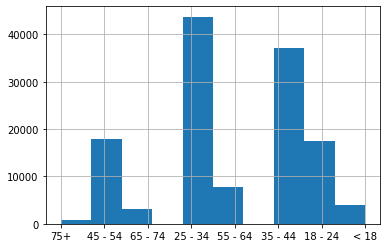

In [12]:
df['age_range_name'].hist()

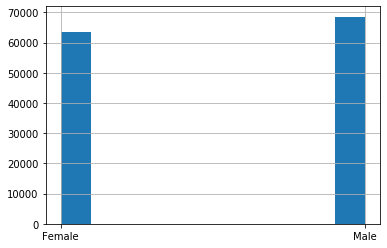

In [13]:
df['gender_name'].hist()

In [14]:
gender_summary_df = df.groupby(by=['gender_name'])['age'].count().to_frame('count').reset_index()

for index, row in gender_summary_df.iterrows():
    print('{}\t{}'.format(row['gender_name'], row['count']))

Female	63525
Male	68552


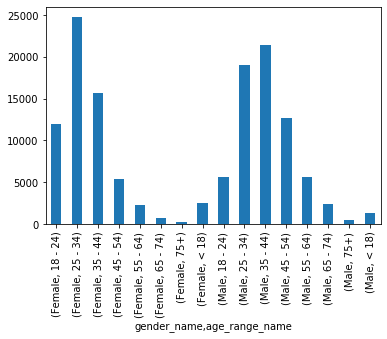

In [15]:
df.groupby(by=['gender_name', 'age_range_name'])['age'].count().plot(kind='bar')

In [16]:
age_range_summary_df = df.groupby(by=['gender_name', 'age_range_name'])['age'].count().to_frame('count').reset_index()

for index, row in age_range_summary_df.iterrows():
    print('{}\t{}\t{}'.format(row['gender_name'], row['age_range_name'], row['count']))

Female	18 - 24	11954
Female	25 - 34	24771
Female	35 - 44	15662
Female	45 - 54	5346
Female	55 - 64	2264
Female	65 - 74	727
Female	75+	233
Female	< 18	2568
Male	18 - 24	5641
Male	25 - 34	18975
Male	35 - 44	21457
Male	45 - 54	12626
Male	55 - 64	5585
Male	65 - 74	2366
Male	75+	527
Male	< 18	1375


In [17]:
train_df = None
validation_df = None
test_df = None

for age_range_id in df.age_range_id.unique():
    split_df, tmp_test_df = sklearn.model_selection.train_test_split(df[df.age_range_id == age_range_id],
                                                                      test_size=0.1)
    tmp_train_df, tmp_validation_df = sklearn.model_selection.train_test_split(split_df, test_size=0.2)
    
    if train_df is None:
        train_df = tmp_train_df.copy(deep=True)
    else:
        train_df = train_df.append(tmp_train_df, ignore_index=True)
        
    if validation_df is None:
        validation_df = tmp_validation_df.copy(deep=True)
    else:
        validation_df = validation_df.append(tmp_validation_df, ignore_index=True)

    if test_df is None:
        test_df = tmp_test_df.copy(deep=True)
    else:
        test_df = test_df.append(tmp_test_df, ignore_index=True)

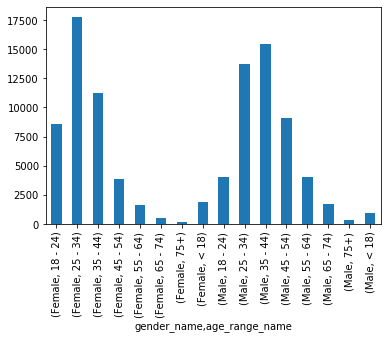

In [18]:
train_df.groupby(by=['gender_name', 'age_range_name'])['age'].count().plot(kind='bar')

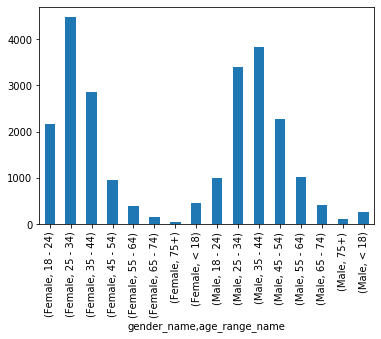

In [19]:
validation_df.groupby(by=['gender_name', 'age_range_name'])['age'].count().plot(kind='bar')

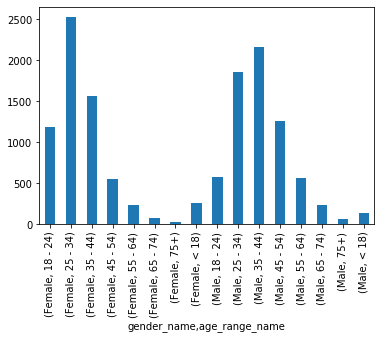

In [20]:
test_df.groupby(by=['gender_name', 'age_range_name'])['age'].count().plot(kind='bar')

In [21]:
print('# of rows in Training data set: {}'.format(len(train_df.index)))

# of rows in Training data set: 95090


In [22]:
print('# of rows in Validation data set: {}'.format(len(validation_df.index)))

# of rows in Validation data set: 23776


In [23]:
print('# of rows in Test data set: {}'.format(len(test_df.index)))

# of rows in Test data set: 13211


In [24]:
train_df.to_csv('train.csv', index=False)
validation_df.to_csv('validation.csv', index=False)
test_df.to_csv('test.csv', index=False)

In [25]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [26]:
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [29]:
BATCH_SIZE = 128

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        #directory=IMAGE_DIRECTORY,
        x_col='file_path',
        y_col='gender_name',
        target_size=(IMAGE_HEIGHT_PIXELS, IMAGE_WIDTH_PIXELS),
        batch_size=BATCH_SIZE,
        shuffle=True,
        class_mode='categorical')

validation_generator = valid_datagen.flow_from_dataframe(
        dataframe=validation_df,
        #directory=IMAGE_DIRECTORY,
        x_col='file_path',
        y_col='gender_name',
        target_size=(IMAGE_HEIGHT_PIXELS, IMAGE_WIDTH_PIXELS),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 95090 validated image filenames belonging to 2 classes.
Found 23776 validated image filenames belonging to 2 classes.


In [30]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu',
                           input_shape=(IMAGE_HEIGHT_PIXELS, IMAGE_WIDTH_PIXELS, IMAGE_COLOR_CHANNELS)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0

In [32]:
EPOCHS = 4

history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_df.index) // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=len(validation_df.index) // BATCH_SIZE)

Epoch 1/4
742/742 [==============================] - 738s 995ms/step - loss: 0.3828 - accuracy: 0.8304 - val_loss: 0.2865 - val_accuracy: 0.8837
Epoch 2/4
742/742 [==============================] - 690s 930ms/step - loss: 0.2784 - accuracy: 0.8887 - val_loss: 0.2621 - val_accuracy: 0.8979
Epoch 3/4
742/742 [==============================] - 696s 938ms/step - loss: 0.2485 - accuracy: 0.9038 - val_loss: 0.2477 - val_accuracy: 0.9062
Epoch 4/4
742/742 [==============================] - 691s 931ms/step - loss: 0.2356 - accuracy: 0.9099 - val_loss: 0.2370 - val_accuracy: 0.9111


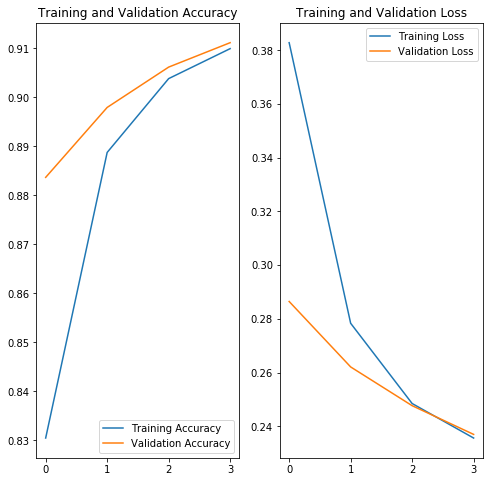

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
model.save('face-only-gender.h5')

In [36]:
gender_predictions = []
gender_results = []

for index, row in test_df.iterrows():
    file_path, gender_id = row['file_path'], row['gender_id']
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=IMAGE_COLOR_CHANNELS)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMAGE_HEIGHT_PIXELS, IMAGE_WIDTH_PIXELS])
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    gender_prediction = prediction[0].argmax()
    gender_result = 0
    if gender_id == gender_prediction:
        gender_result = 1
    gender_predictions.append(gender_prediction)
    gender_results.append(gender_result)


test_results_df = test_df.copy()
test_results_df['gender_predicted'] = gender_predictions
test_results_df['gender_result'] = gender_results

In [37]:
test_results_df.to_csv('test_results.csv', index=False)

In [38]:
print('Overall Gender Test Accuracy: {:.2%}'.format(test_results_df['gender_result'].sum() / len(test_results_df.index)))

Overall Gender Test Accuracy: 91.22%


In [40]:
age_ranges = test_results_df.age_range_name.unique()
age_ranges.sort()

for age_range_name in age_ranges:
    age_range_df = test_results_df[test_results_df.age_range_name == age_range_name]
    print('Accuracy for {}:'.format(age_range_name))
    number_of_images = len(age_range_df.index)
    print('- Number of images: {}'.format(number_of_images))
    print('- Gender Accuracy: {:.2%}'.format(age_range_df['gender_result'].sum() / len(age_range_df.index)))
    number_of_female_images = len(age_range_df[age_range_df.gender_id == 0].index)
    number_of_male_images = len(age_range_df[age_range_df.gender_id == 1].index)
    print('  - Incorrect predictions for Female: {:.2%}'.format(
            age_range_df[(age_range_df.gender_id == 0) & (age_range_df.gender_predicted == 1)].gender_predicted.count() / number_of_female_images))
    print('  - Incorrect predictions for Male: {:.2%}'.format(
            age_range_df[(age_range_df.gender_id == 1) & (age_range_df.gender_predicted == 0)].gender_predicted.count() / number_of_male_images))
    print()

Accuracy for 18 - 24:
- Number of images: 1760
- Gender Accuracy: 89.55%
  - Incorrect predictions for Female: 8.11%
  - Incorrect predictions for Male: 15.25%

Accuracy for 25 - 34:
- Number of images: 4375
- Gender Accuracy: 91.02%
  - Incorrect predictions for Female: 9.78%
  - Incorrect predictions for Male: 7.90%

Accuracy for 35 - 44:
- Number of images: 3712
- Gender Accuracy: 92.19%
  - Incorrect predictions for Female: 10.80%
  - Incorrect predictions for Male: 5.66%

Accuracy for 45 - 54:
- Number of images: 1798
- Gender Accuracy: 91.82%
  - Incorrect predictions for Female: 12.07%
  - Incorrect predictions for Male: 6.47%

Accuracy for 55 - 64:
- Number of images: 785
- Gender Accuracy: 92.23%
  - Incorrect predictions for Female: 14.60%
  - Incorrect predictions for Male: 5.01%

Accuracy for 65 - 74:
- Number of images: 310
- Gender Accuracy: 91.29%
  - Incorrect predictions for Female: 12.50%
  - Incorrect predictions for Male: 7.56%

Accuracy for 75+:
- Number of images:

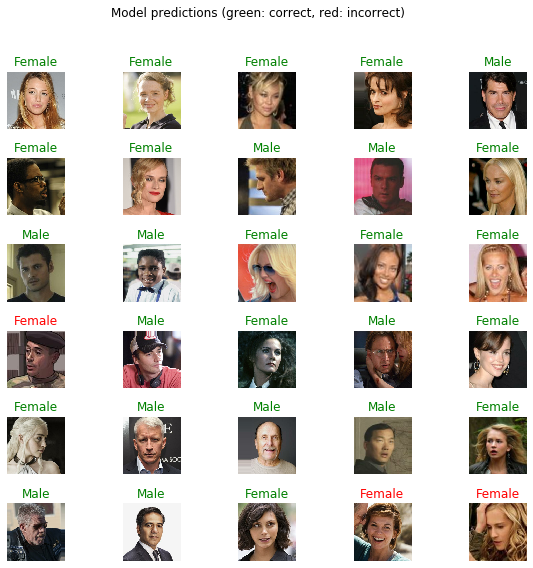

In [43]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

counter = 1
for index, row in test_results_df.sample(30).iterrows():
    plt.subplot(6,5, counter)
    image = tf.io.read_file(row['file_path'])
    image = tf.image.decode_jpeg(image, channels=3) #color images
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    plt.imshow(image)
    color = "green" if row['gender_id'] == row['gender_predicted'] else "red"
    title = 'Female' if row['gender_predicted'] == 0 else 'Male'
    plt.title(title, color=color)
    plt.axis('off')
    counter = counter + 1

_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")